In [1]:
#import necessary libraries
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn_pandas import DataFrameMapper
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from pycox.models import CoxPH, DeepHit

from pycox.evaluation import EvalSurv
from pycox.simulations import SimStudyLinearPH

import torch
import torchtuples as tt

In [2]:
#url = 'https://raw.githubusercontent.com/camicallierotti/imperial-summer-project/main/pbc.csv'
df = pd.read_csv('pbc.csv')
df = pd.DataFrame(df)

In [3]:
df.head()

,id,time,status,trt,age,sex,ascites,hepato,spiders,edema,bili,chol,albumin,copper,alk.phos,ast,trig,platelet,protime,stage
0,1,400,2,1.0,58.765229,f,1.0,1.0,1.0,1.0,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,2,4500,0,1.0,56.446270,f,0.0,1.0,1.0,0.0,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,3,1012,2,1.0,70.072553,m,0.0,0.0,0.0,0.5,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,4,1925,2,1.0,54.740589,f,0.0,1.0,1.0,0.5,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,5,1504,1,2.0,38.105407,f,0.0,1.0,1.0,0.0,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


In [4]:
# to label encoding categorical variables
le = LabelEncoder() #label encoder
'''cat_list = ['trt', 'age', 'sex', 'ascites', 'hepato', 'spiders', 'edema','stage'] #list of categorical variables
for cat in cat_list:
    df[cat] = le.fit_transform(df[cat])'''
df['sex'] = le.fit_transform(df['sex'])

In [5]:
df.head()

,id,time,status,trt,age,sex,ascites,hepato,spiders,edema,bili,chol,albumin,copper,alk.phos,ast,trig,platelet,protime,stage
0,1,400,2,1.0,58.765229,0,1.0,1.0,1.0,1.0,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,2,4500,0,1.0,56.446270,0,0.0,1.0,1.0,0.0,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,3,1012,2,1.0,70.072553,1,0.0,0.0,0.0,0.5,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,4,1925,2,1.0,54.740589,0,0.0,1.0,1.0,0.5,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,5,1504,1,2.0,38.105407,0,0.0,1.0,1.0,0.0,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


In [6]:
# summary of the data set
df.isnull().sum() # number of missing values

id            0
time          0
status        0
trt         106
age           0
sex           0
ascites     106
hepato      106
spiders     106
edema         0
bili          0
chol        134
albumin       0
copper      108
alk.phos    106
ast         106
trig        136
platelet     11
protime       2
stage         6
dtype: int64

In [7]:
# to check if there are missing values in the variables 
print(f'total numbers of missing values :{df.isnull().sum().max()} and total rows in dataframe {len(df)}')

total numbers of missing values :136 and total rows in dataframe 418


In [8]:
# to drop missing value from the dataframe
df_new = df
df_new.dropna(how='any', inplace= True)

In [9]:
len(df_new)

276

In [10]:
# descriptive of the data i
df_new.describe()

,id,time,status,trt,age,sex,ascites,hepato,spiders,edema,bili,chol,albumin,copper,alk.phos,ast,trig,platelet,protime,stage
count,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000
mean,158.615942,1979.166667,0.869565,1.507246,49.799661,0.123188,0.068841,0.514493,0.289855,0.106884,3.333696,371.260870,3.516812,100.768116,1996.611594,124.119239,124.978261,261.771739,10.735507,3.039855
std,91.662926,1112.380295,0.959743,0.500856,10.523082,0.329250,0.253643,0.500698,0.454519,0.270333,4.601074,234.788363,0.404789,88.268746,2115.477894,56.719952,65.280761,93.128857,1.008315,0.853999
min,1.000000,41.000000,0.000000,1.000000,26.277892,0.000000,0.000000,0.000000,0.000000,0.000000,0.300000,120.000000,1.960000,4.000000,289.000000,28.380000,33.000000,62.000000,9.000000,1.000000
25%,79.750000,1185.750000,0.000000,1.000000,41.512663,0.000000,0.000000,0.000000,0.000000,0.000000,0.800000,249.500000,3.310000,42.750000,922.500000,82.457500,85.000000,200.000000,10.000000,2.000000
50%,157.500000,1788.000000,0.000000,2.000000,49.709788,0.000000,0.000000,1.000000,0.000000,0.000000,1.400000,310.000000,3.545000,74.000000,1277.500000,116.625000,108.000000,257.000000,10.600000,3.000000
75%,240.250000,2689.750000,2.000000,2.000000,56.584531,0.000000,0.000000,1.000000,1.000000,0.000000,3.525000,401.000000,3.772500,129.250000,2068.250000,153.450000,151.250000,318.250000,11.200000,4.000000
max,312.000000,4556.000000,2.000000,2.000000,78.439425,1.000000,1.000000,1.000000,1.000000,1.000000,28.000000,1775.000000,4.400000,588.000000,13862.400000,457.250000,598.000000,563.000000,17.100000,4.000000


In [11]:
data_train = df_new #train data 
data_test = df_new.sample(frac= 0.2) #test data
data_val = df_new.sample (frac= 0.2) #val data

In [12]:
# function to get targets variable
Y = lambda df_new: (df_new['time'].values, df_new['status'].values)

# to standardize and get dependent variables 
x_num = ['age','bili', 'chol', 'albumin', 'copper', 'alk.phos',
       'ast', 'trig', 'platelet', 'protime'] # list of variables for standardization
x_cat = ['trt','sex', 'ascites', 'hepato',
       'spiders', 'edema', 'stage'] #categorical variables 
standardize = [([num], StandardScaler()) for num in x_num]
label = [([cat], None) for cat in x_cat]

X_map = DataFrameMapper(standardize + label)

In [13]:
x_train = X_map.fit_transform(data_train).astype('float32') # x train
x_test= X_map.fit_transform(data_test).astype('float32') # x test
x_val = X_map.fit_transform(data_val).astype('float32') # x va


In [14]:
y_train = Y(data_train) # y train
time_test , status_test = Y(data_test) # test dependent variables Time & Status
y_val = Y(data_val) # y val
val = x_val, y_val # validation data for x and y 

In [15]:
len(y_train)

2

# Building the neural network model for PHCOX

In [16]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = 1
batch_norm = True
dropout = 0.1
output_bias = False

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                              dropout, output_bias=output_bias)

In [17]:
model_cox = CoxPH(net, tt.optim.Adam) #cox model on the neural network with Adam optimizer

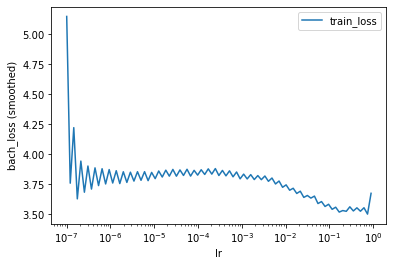

In [18]:
#learning rate for the cox model
lrfinder_cox = model_cox.lr_finder(x_train, y_train, batch_size = 256, tolerance=10) 
_ = lrfinder_cox.plot()

In [19]:
# setting the learnig rate 
model_cox.optimizer.set_lr(0.001)

In [22]:
epochs = 512
callbacks = [tt.callbacks.EarlyStopping()]
#callbacks = None
verbose = True
batch_size = 256

log_cox = model_cox.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data =val,  val_batch_size=batch_size)

57:	[0s / 0s],		train_loss: 3.2140,	val_loss: 2.4504
58:	[0s / 0s],		train_loss: 3.2207,	val_loss: 2.4399
59:	[0s / 0s],		train_loss: 3.1313,	val_loss: 2.4302
60:	[0s / 0s],		train_loss: 3.0168,	val_loss: 2.4368
61:	[0s / 0s],		train_loss: 2.8982,	val_loss: 2.4422
62:	[0s / 0s],		train_loss: 2.7793,	val_loss: 2.4313
63:	[0s / 0s],		train_loss: 3.0692,	val_loss: 2.4233
64:	[0s / 0s],		train_loss: 2.8566,	val_loss: 2.4158
65:	[0s / 0s],		train_loss: 3.0206,	val_loss: 2.4118
66:	[0s / 0s],		train_loss: 2.8512,	val_loss: 2.4153
67:	[0s / 0s],		train_loss: 3.0142,	val_loss: 2.4178
68:	[0s / 0s],		train_loss: 2.9697,	val_loss: 2.4085
69:	[0s / 0s],		train_loss: 3.0000,	val_loss: 2.3972
70:	[0s / 0s],		train_loss: 2.9559,	val_loss: 2.3892
71:	[0s / 0s],		train_loss: 3.2163,	val_loss: 2.3766
72:	[0s / 0s],		train_loss: 3.0671,	val_loss: 2.3846
73:	[0s / 0s],		train_loss: 2.8967,	val_loss: 2.3821
74:	[0s / 0s],		train_loss: 3.0650,	val_loss: 2.3794
75:	[0s / 0s],		train_loss: 2.9519,	val_loss: 

Text(0, 0.5, 'Loss')

<Figure size 864x864 with 0 Axes>

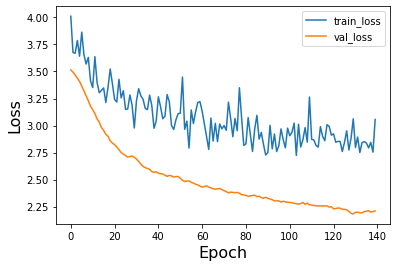

In [23]:
#plotting the loss vs epoch 
plt.figure(figsize=[12,12])
log_cox.plot()
plt.xlabel('Epoch', fontsize = 16)
plt.ylabel('Loss', fontsize = 16)

In [24]:
# predict for the cox model
model_cox.compute_baseline_hazards() #baseline hazard
surv_cox = model_cox.predict_surv_df(x_test) # survival of the test data

In [56]:
surv_cox

,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,54
duration,,,,,,,,,,,,,,,,,,,,,
41,0.997653,0.999562,9.870106e-01,0.999439,9.737133e-01,0.999657,9.521895e-01,0.998691,0.999852,0.999606,...,0.998678,0.999340,0.999383,0.997971,0.999817,0.999303,0.996293,0.999336,0.998876,0.999905
51,0.994638,0.998998,9.705247e-01,0.998717,9.408639e-01,0.999216,8.939485e-01,0.997008,0.999662,0.999098,...,0.996978,0.998491,0.998589,0.995363,0.999581,0.998406,0.991538,0.998482,0.997431,0.999783
71,0.991537,0.998417,9.538065e-01,0.997973,9.081377e-01,0.998761,8.375983e-01,0.995274,0.999466,0.998574,...,0.995227,0.997615,0.997771,0.992680,0.999338,0.997481,0.986657,0.997601,0.995941,0.999657
77,0.988421,0.997831,9.372470e-01,0.997224,8.763034e-01,0.998303,7.843945e-01,0.993530,0.999268,0.998047,...,0.993465,0.996733,0.996946,0.989983,0.999093,0.996549,0.981761,0.996714,0.994443,0.999530
110,0.985186,0.997222,9.203061e-01,0.996444,8.443343e-01,0.997825,7.325730e-01,0.991717,0.999062,0.997497,...,0.991634,0.995816,0.996088,0.987182,0.998837,0.995580,0.976688,0.995791,0.992884,0.999398
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4427,0.000361,0.228188,6.974307e-20,0.150760,9.330009e-40,0.314668,1.654951e-72,0.012061,0.607571,0.264250,...,0.011537,0.107853,0.124725,0.001057,0.539063,0.095122,0.000004,0.106424,0.022529,0.726387
4500,0.000361,0.228188,6.974307e-20,0.150760,9.330009e-40,0.314668,1.654951e-72,0.012061,0.607571,0.264250,...,0.011537,0.107853,0.124725,0.001057,0.539063,0.095122,0.000004,0.106424,0.022529,0.726387
4509,0.000361,0.228188,6.974307e-20,0.150760,9.330009e-40,0.314668,1.654951e-72,0.012061,0.607571,0.264250,...,0.011537,0.107853,0.124725,0.001057,0.539063,0.095122,0.000004,0.106424,0.022529,0.726387


In [25]:
surv_cox.to_csv('Predict _survival')

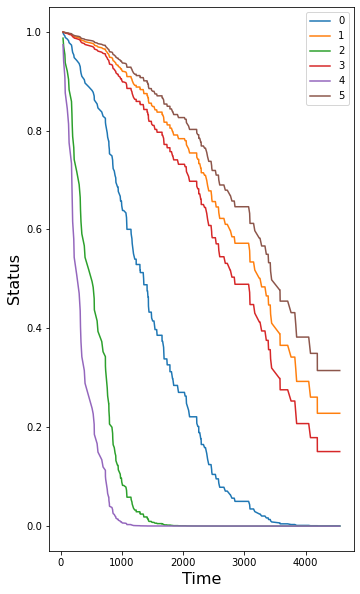

In [26]:
# plotting for few outputs
plt.figure(figsize=[12,10])
plt.subplot(121)
plt.plot(surv_cox.iloc[:, :6])
plt.xlabel('Time', fontsize = 16)
plt.ylabel('Status' , fontsize = 16)
plt.legend(range(len(surv_cox.iloc[:, :20])))

In [27]:
# evaluate the c-index of the cox model 
eval_cox = EvalSurv(surv_cox, time_test, status_test, censor_surv= 'km')
cox_index = eval_cox.concordance_td() 

In [28]:
cox_index 

0.7151515151515152

## Model DEEP HIT


In [29]:
from pycox.models import DeepHit
from pycox.preprocessing import label_transforms, discretization


In [30]:
# building the net
class CauseSpecificNet(torch.nn.Module):
    """Network structure similar to the DeepHit paper, but without the residual
    connections (for simplicity).
    """
    def __init__(self, in_features, num_nodes_shared, num_nodes_indiv, num_risks,
                 out_features, batch_norm=True, dropout=None):
        super().__init__()
        self.shared_net = tt.practical.MLPVanilla(
            in_features, num_nodes_shared[:-1], num_nodes_shared[-1],
            batch_norm, dropout,
        )
        self.risk_nets = torch.nn.ModuleList()
        for _ in range(num_risks):
            net = tt.practical.MLPVanilla(
                num_nodes_shared[-1], num_nodes_indiv, out_features,
                batch_norm, dropout,
            )
            self.risk_nets.append(net)

    def forward(self, input):
        out = self.shared_net(input)
        out = [net(out) for net in self.risk_nets]
        out = torch.stack(out, dim=1)
        return out

In [31]:
from pycox.preprocessing.label_transforms import LabTransDiscreteTime
class LabTransform(LabTransDiscreteTime):
    def transform(self, durations, events):
        durations, is_event = super().transform(durations, events > 0)
        events[is_event == 0] = 0
        return durations, events.astype('int64')

In [32]:
# transforming y variables
num_durations = 10
labtrans = LabTransform(num_durations)

get_target = lambda df: (df['duration'].values, df['event'].values)
y_train_i = labtrans.fit_transform(*Y(data_train)) # y_train transformed
y_val_i = labtrans.transform(*Y(data_val)) #Y_val transformed

train = (x_train, y_train_i) # training data with transformed y 
val_i = (x_val, y_val_i)

# We don't need to transform the test labels
time_test, status_test = Y(data_test)

In [33]:
in_features = x_train.shape[1]
num_nodes_shared = [64, 64]
num_nodes_indiv = [32]
num_risks = int(y_train[1].max())
out_features = len(labtrans.cuts)
batch_norm = True
dropout = 0.1

# net = SimpleMLP(in_features, num_nodes_shared, num_risks, out_features)
net_ = CauseSpecificNet(in_features, num_nodes_shared, num_nodes_indiv, num_risks,
                       out_features, batch_norm, dropout)

In [34]:
optimizer = tt.optim.AdamWR(lr=0.01, decoupled_weight_decay=0.01,
                            cycle_eta_multiplier=0.8)
model_deep = DeepHit(net_, optimizer, alpha=0.2, sigma=0.1,
                duration_index=labtrans.cuts)

In [35]:
epochs = 512
batch_size = 256
callbacks = [tt.callbacks.EarlyStoppingCycle()]
verbose = False # set to True if you want printout

In [36]:
#log_deep = model_deep.fit(x_train, y_train, batch_size, epochs, callbacks, verbose, val_data=val)
log_deep = model_deep.fit(x_train, y_train_i, batch_size, epochs, callbacks, verbose, val_data=val_i)

C:\Users\user\anaconda3\lib\site-packages\torchtuples\callbacks.py:607: UserWarning: This overload of add is deprecated:
	add(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add(Tensor other, *, Number alpha) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:1025.)
  p.data = p.data.add(-weight_decay * eta, p.data)


<AxesSubplot:>

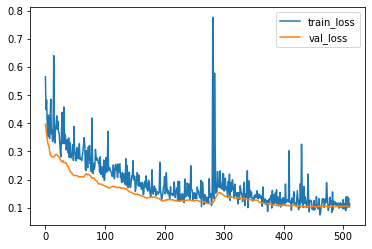

In [37]:
#
log_deep.plot()

In [38]:
# to predict
surv_deep = model_deep.predict_surv_df(x_test)
surv_deep.to_csv('Survival DeepHit')

In [39]:
# to evaluate
eval_deep = EvalSurv(surv_deep, time_test, status_test , censor_surv='km')

In [40]:
# c -index
c_index_deep = eval_deep.concordance_td()
c_index_deep

0.4727272727272727

## Predict min, median and max age

In [41]:
np.median(df['age']), np.min(df['age']), np.max(df['age'])

(49.709787816564, 26.2778918548939, 78.4394250513347)

In [42]:
### rslt_df = dataframe[dataframe['Percentage'] > 80]
min_age = df_new.loc[df_new['age'] == 26.2778918548939]
max_age = df_new.loc[df_new['age'] == 78.4394250513347]
median_age =df_new.loc[(df_new['age'] ==49.5605749486653 )]

In [81]:
median_age 

,id,time,status,trt,age,sex,ascites,hepato,spiders,edema,bili,chol,albumin,copper,alk.phos,ast,trig,platelet,protime,stage
18,19,4232,0,1.0,49.560575,0,0.0,1.0,0.0,0.5,0.7,235.0,3.56,39.0,1881.0,93.0,123.0,209.0,11.0,3.0


In [82]:
# convert data to float
max_age_x = X_map.fit_transform(max_age).astype('float32') 
min_age_x = X_map.fit_transform(min_age).astype('float32')
median_age_x = X_map.fit_transform(median_age).astype('float32')


## COX MODEL

In [83]:
# predict for each of the age group
model_cox.compute_baseline_hazards()
surv_max_cox = model_cox.predict_surv_df(max_age_x ) # max
surv_min_cox = model_cox.predict_surv_df(min_age_x ) # min
surv_med_cox = model_cox.predict_surv_df(median_age_x ) # median

max_time, max_status = Y(max_age)
min_time, min_status = Y(min_age)
median_time, median_status = Y(median_age)


In [72]:
max_time, max_status

(array([1765], dtype=int64), array([0], dtype=int64))

<AxesSubplot:xlabel='duration'>

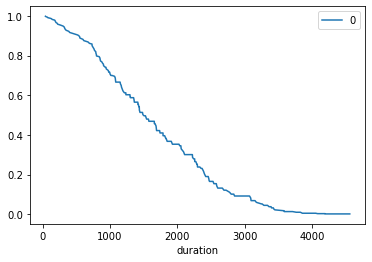

In [67]:
surv_min_cox.plot()

In [ ]:
surv

In [88]:
# evaluate survival prediction for each of the age group
eval_cox_max = EvalSurv(surv_max_cox, max_time, max_status ) # max
eval_cox_min = EvalSurv(surv_min_cox, min_time,min_status ) # min
eval_cox_med = EvalSurv(surv_med_cox, median_time, median_status) # median

In [89]:
# c-index for each of the age group
cox_max_index = eval_cox_max.concordance_td(method='antolini')
cox_min_index = eval_cox_min.concordance_td()
cox_med_index = eval_cox_med.concordance_td()


ZeroDivisionError: float division by zero

# DeepHIt

In [61]:
# predict for each of the age group
surv_max_deep = model_deep.predict_surv_df(max_age_x ) # max
surv_min_deep = model_deep.predict_surv_df(min_age_x ) # min
surv_med_deep = model_deep.predict_surv_df(median_age_x ) # median

In [62]:
# evaluate survival prediction for each of the age group
# evaluate survival prediction for each of the age group
eval_deep_max = EvalSurv(surv_max_deep, max_time, max_status, censor_surv='km') # max
eval_deep_min = EvalSurv(surv_max_deep, min_time,min_status ) # min
eval_deep_med = EvalSurv(surv_max_deep, median_time, median_status) # median

In [63]:
# c-index for each of the age group
deep_max_index = eval_deep_max.concordance_td()
deep_min_index = eval_deep_min.concordance_td()
deep_med_index = eval_deep_med.concordance_td()

ZeroDivisionError: float division by zero

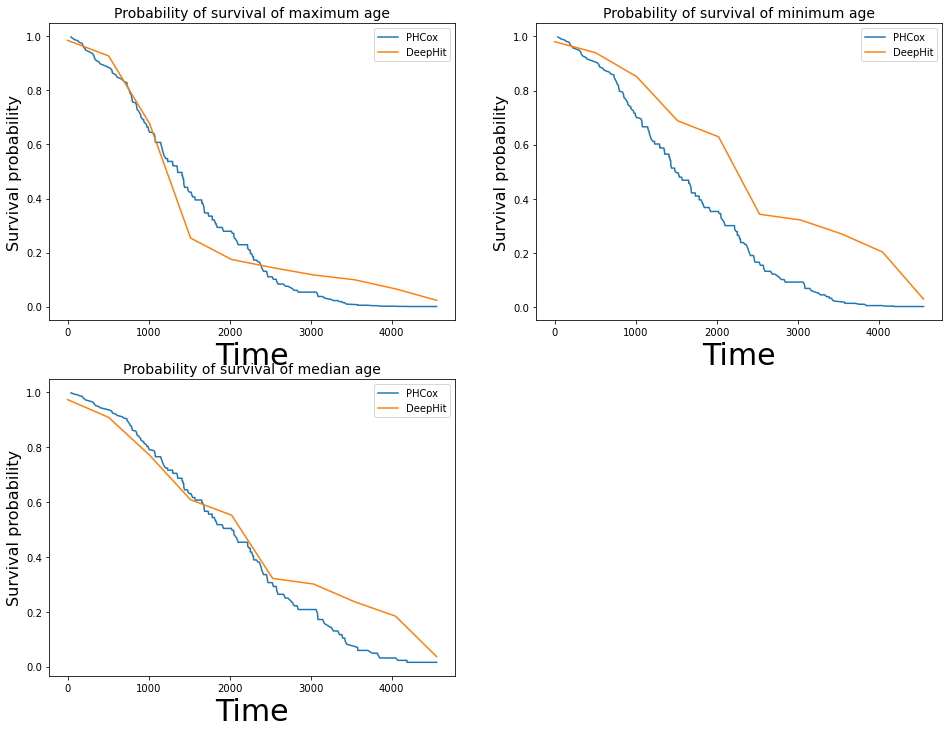

In [64]:
plt.figure(figsize=[16,12])
plt.subplot(221)
plt.plot(surv_max_cox)
plt.plot(surv_max_deep )
plt.xlabel('Time', fontsize = 30)
plt.ylabel('Survival probability', fontsize = 16)
plt.title('Probability of survival of maximum age', fontsize = 14)
plt.legend(['PHCox', 'DeepHit'])

plt.subplot(222)
plt.plot(surv_min_cox)
plt.plot(surv_min_deep )
plt.xlabel('Time', fontsize = 30)
plt.ylabel('Survival probability', fontsize = 16)
plt.title('Probability of survival of minimum age', fontsize = 14)
plt.legend(['PHCox', 'DeepHit'])

plt.subplot(223)
plt.plot(surv_med_cox)
plt.plot(surv_med_deep )
plt.xlabel('Time', fontsize = 30)
plt.ylabel('Survival probability', fontsize = 16)
plt.title('Probability of survival of median age', fontsize = 14)
plt.legend(['PHCox', 'DeepHit'])

# STIMULATED AT DIFFERENT CENSOR RATE

In [ ]:
from pycox.simulations import base 
from pycox.simulations import discrete_logit_hazard , relative_risk, SimStudyLinearPH, SimStudySACCensorConst


In [ ]:
#Different censoring rate
a1 = SimStudyLinearPH(c0 = 1) # 1%
a25 = SimStudyLinearPH(c0 = 25) # 25 %
a50 = SimStudyLinearPH(c0 = 50) # 50%
a75= SimStudyLinearPH(c0 = 75) # 75%
a100= SimStudyLinearPH(c0 = 99) # 99%

In [ ]:
#function to create simulated 
def data_pre(var):
    # dataframe from the simulation
    data = var.dict2df(var.simulate(1000))
    train = data
    test = data.sample(frac=0.2)
    val= data.sample(frac=0.2)
    return train, test, val



In [ ]:
# function to standardize X 
def stand_data(data):
    # data is dataframe to standardize
    Y= lambda data: (data['duration'].values, data['event'].values)

    # to standardize and get dependent variables 
    X= ['x0', 'x1', 'x2', 'duration_true', 'event_true',
       'censoring_true'] # list of variables for standardization

    standardize_sim = [([sim], StandardScaler()) for sim in X] #standardize function 
    

    X_map_sim = DataFrameMapper(standardize_sim)
    x = X_map_sim.fit_transform(data).astype('float32') # x simulate data
    
    y = Y(data) # y variables
    return x, y


In [ ]:
# function to create neural network
def arch_net (x_data):
    # x_data x dataframe
    in_features = x_data.shape[1]
    num_nodes = [32, 32]
    out_features = 1
    batch_norm = True
    dropout = 0.1
    output_bias = False

    net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                                  dropout, output_bias=output_bias)
    return net


In [ ]:
# 1%
df_train_1, df_test_1, df_val_1 = data_pre(a1)

In [ ]:
x_train_50 , y_train_50 = stand_data(df_train_50)
x_test_50 = stand_data(df_test_50)[0] # x test 
duration_test_50, event_test_50 = stand_data(df_test_50)[1] #y _test
val_50 = stand_data(df_val_50)

In [ ]:
# net for 50%
net_50 = arch_net(x_train_50)
model_cox_50 = CoxPH(net_50, tt.optim.Adam) #cox model on the neural network with Adam optimizer

In [ ]:
# net for 50% 
lrfinder_cox_50 = model_cox_50.lr_finder(x_train_50, y_train_50, batch_size = 256, tolerance=10) 
_ = lrfinder_cox_50.plot()

In [ ]:
# setting the learnig rate 
model_cox_50.optimizer.set_lr(0.0050)

In [ ]:
epochs = 512
callbacks = [tt.callbacks.EarlyStopping()]
#callbacks = None
verbose = True
batch_size = 256

log_cox_50 = model_cox_50.fit(x_train_50, y_train_50, batch_size, epochs, callbacks, verbose,
                val_data =val_50,  val_batch_size=batch_size)

In [ ]:
#plotting the loss vs epoch 
plt.figure(figsize=[502,502])
log_cox_50.plot()
plt.xlabel('Epoch', fontsize = 16)
plt.ylabel('Loss', fontsize = 16)

In [ ]:
# predict for the cox model
model_cox_50.compute_baseline_hazards() #baseline hazard
surv_cox_50 = model_cox_50.predict_surv_df(x_test_50) # survival of the test data

In [ ]:
# plotting for few outputs
plt.figure(figsize=[8,12])
plt.subplot()
plt.plot(surv_cox_50.iloc[:, :6])
plt.xlabel('Time', fontsize = 16)
plt.ylabel('Status' , fontsize = 16)
plt.legend(range(len(surv_cox.iloc[:, :20])))

In [ ]:
# evaluate the c-index of the cox model 
eval_cox_50 = EvalSurv(surv_cox_50, duration_test_50, event_test_50)
cox_index_50 = eval_cox_50.concordance_td() 
cox_index_50

## 25% CENSORING RATE




In [ ]:
df_train_25, df_test_25, df_val_25 = data_pre(a25)

In [ ]:
x_train_25 , y_train_25 = stand_data(df_train_25)
x_test_25 = stand_data(df_test_25)[0] # x test 
duration_test_25, event_test_25 = stand_data(df_test_25)[1] #y _test
val_25 = stand_data(df_val_25)

In [ ]:
# net for 25%
net_25 = arch_net(x_train_25)
model_cox_25 = CoxPH(net_25, tt.optim.Adam) #cox model on the neural network with Adam optimizer

In [ ]:
# net for 25% 
lrfinder_cox_25 = model_cox_25.lr_finder(x_train_25, y_train_25, batch_size = 256, tolerance=250) 
_ = lrfinder_cox_25.plot()

In [ ]:
# setting the learnig rate 
model_cox_25.optimizer.set_lr(0.0025)

In [ ]:
epochs = 5252
callbacks = [tt.callbacks.EarlyStopping()]
#callbacks = None
verbose = True
batch_size = 256

log_cox_25 = model_cox_25.fit(x_train_25, y_train_25, batch_size, epochs, callbacks, verbose,
                val_data =val_25,  val_batch_size=batch_size)

In [ ]:
#plotting the loss vs epoch 
plt.figure(figsize=[252,252])
log_cox_25.plot()
plt.xlabel('Epoch', fontsize = 16)
plt.ylabel('Loss', fontsize = 16)

In [ ]:
# predict for the cox model
model_cox_25.compute_baseline_hazards() #baseline hazard
surv_cox_25 = model_cox_25.predict_surv_df(x_test_25) # survival of the test data

In [ ]:
# plotting for few outputs
plt.figure(figsize=[252,250])
plt.subplot()
plt.plot(surv_cox_25.iloc[:, :6])
plt.xlabel('Time', fontsize = 16)
plt.ylabel('Status' , fontsize = 16)
plt.legend(range(len(surv_cox.iloc[:, :20])))

In [ ]:
# evaluate the c-index of the cox model 
eval_cox_25 = EvalSurv(surv_cox_25, duration_test_25, event_test_25)
cox_index_25 = eval_cox_25.concordance_td() 
cox_index_25

## 50% CENSORING RATE




In [ ]:
df_train_50, df_test_50, df_val_50 = data_pre(a50)

In [ ]:
x_train_50 , y_train_50 = stand_data(df_train_50)
x_test_50 = stand_data(df_test_50)[0] # x test 
duration_test_50, event_test_50 = stand_data(df_test_50)[1] #y _test
val_50 = stand_data(df_val_50)

In [ ]:
# net for 50%
net_50 = arch_net(x_train_50)
model_cox_50 = CoxPH(net_50, tt.optim.Adam) #cox model on the neural network with Adam optimizer

In [ ]:
# net for 50% 
lrfinder_cox_50 = model_cox_50.lr_finder(x_train_50, y_train_50, batch_size = 256, tolerance=10) 
_ = lrfinder_cox_50.plot()

In [ ]:
# setting the learnig rate 
model_cox_50.optimizer.set_lr(0.0050)

In [ ]:
epochs = 512
callbacks = [tt.callbacks.EarlyStopping()]
#callbacks = None
verbose = True
batch_size = 256

log_cox_50 = model_cox_50.fit(x_train_50, y_train_50, batch_size, epochs, callbacks, verbose,
                val_data =val_50,  val_batch_size=batch_size)

In [ ]:
#plotting the loss vs epoch 
plt.figure(figsize=[502,502])
log_cox_50.plot()
plt.xlabel('Epoch', fontsize = 16)
plt.ylabel('Loss', fontsize = 16)

In [ ]:
# predict for the cox model
model_cox_50.compute_baseline_hazards() #baseline hazard
surv_cox_50 = model_cox_50.predict_surv_df(x_test_50) # survival of the test data

In [ ]:
# plotting for few outputs
plt.figure(figsize=[8,12])
plt.subplot()
plt.plot(surv_cox_50.iloc[:, :6])
plt.xlabel('Time', fontsize = 16)
plt.ylabel('Status' , fontsize = 16)
plt.legend(range(len(surv_cox.iloc[:, :20])))

In [ ]:
# evaluate the c-index of the cox model 
eval_cox_50 = EvalSurv(surv_cox_50, duration_test_50, event_test_50)
cox_index_50 = eval_cox_50.concordance_td() 
cox_index_50

##  &% % CENSORING RATE

In [ ]:
df_train_50, df_test_50, df_val_50 = data_pre(a50)

In [ ]:
x_train_50 , y_train_50 = stand_data(df_train_50)
x_test_50 = stand_data(df_test_50)[0] # x test 
duration_test_50, event_test_50 = stand_data(df_test_50)[1] #y _test
val_50 = stand_data(df_val_50)

In [ ]:
# net for 50%
net_50 = arch_net(x_train_50)
model_cox_50 = CoxPH(net_50, tt.optim.Adam) #cox model on the neural network with Adam optimizer

In [ ]:
# net for 50% 
lrfinder_cox_50 = model_cox_50.lr_finder(x_train_50, y_train_50, batch_size = 256, tolerance=10) 
_ = lrfinder_cox_50.plot()

In [ ]:
# setting the learnig rate 
model_cox_50.optimizer.set_lr(0.0050)

In [ ]:
epochs = 512
callbacks = [tt.callbacks.EarlyStopping()]
#callbacks = None
verbose = True
batch_size = 256

log_cox_50 = model_cox_50.fit(x_train_50, y_train_50, batch_size, epochs, callbacks, verbose,
                val_data =val_50,  val_batch_size=batch_size)

In [ ]:
#plotting the loss vs epoch 
plt.figure(figsize=[502,502])
log_cox_50.plot()
plt.xlabel('Epoch', fontsize = 16)
plt.ylabel('Loss', fontsize = 16)

In [ ]:
# predict for the cox model
model_cox_50.compute_baseline_hazards() #baseline hazard
surv_cox_50 = model_cox_50.predict_surv_df(x_test_50) # survival of the test data

In [ ]:
# plotting for few outputs
plt.figure(figsize=[8,12])
plt.subplot()
plt.plot(surv_cox_50.iloc[:, :6])
plt.xlabel('Time', fontsize = 16)
plt.ylabel('Status' , fontsize = 16)
plt.legend(range(len(surv_cox.iloc[:, :20])))

In [ ]:
# evaluate the c-index of the cox model 
eval_cox_50 = EvalSurv(surv_cox_50, duration_test_50, event_test_50)
cox_index_50 = eval_cox_50.concordance_td() 
cox_index_50